<a href="https://colab.research.google.com/github/pedro-surf/university-exercises/blob/master/IA_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Comparação de algoritmos — Classificação (Titanic) e Regressão (House Prices)

> Descrição dos datasets, pré-processamento, treino de 2 modelos para classificação e 2 para regressão usando scikit-learn, comparação de métricas e gráficos.


## 1) Imports e instalação

In [1]:
# !pip install kaggle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)

sns.set_style('whitegrid')
%matplotlib inline



## 2) Datasets escolhidos

* **Classificação:** *Titanic - Machine Learning from Disaster* (Kaggle). Objetivo: prever se um passageiro sobreviveu (`Survived` = 0/1).

* **Regressão:** *House Prices - Advanced Regression Techniques* (Kaggle). Objetivo: prever `SalePrice` (valor da casa).
---

## 3) Carregando os dados


In [2]:

titanic = pd.read_csv('train_titanic.csv')
houses = pd.read_csv('train_house_prices.csv')

print('Titanic shape:', titanic.shape)
print('Houses shape:', houses.shape)

display(titanic.head())
display(houses.head())

Titanic shape: (891, 12)
Houses shape: (1460, 81)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



## 4) Exploração e pré-processamento — Titanic

**Descrição rápida de tratamento:** remover ou transformar colunas inúteis (`Ticket`, `Name`, `PassengerId`, `Cabin`), imputar `Age` e `Embarked`, codificar `Sex` e `Embarked`, escala dos atributos numéricos se necessário.

In [3]:
# Copy para não alterar o original
tt = titanic.copy()

# Colunas que tipicamente não ajudam sem engenharia adicional
tt.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True, errors='ignore')

# Separar target
y_t = tt['Survived']
X_t = tt.drop('Survived', axis=1)

# Identificar tipos
num_cols = X_t.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_t.select_dtypes(include=['object']).columns.tolist()

print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

# Pipeline de pré-processamento
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preproc_titanic = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Preparar conjuntos de treino/teste
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42, stratify=y_t)

# Exemplo: transformar os dados prontos para modelos
X_t_train_prep = preproc_titanic.fit_transform(X_t_train)
X_t_test_prep = preproc_titanic.transform(X_t_test)

print('Shape after preprocess (train):', X_t_train_prep.shape)


num_cols: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols: ['Sex', 'Embarked']
Shape after preprocess (train): (712, 10)
[[ 0.82956755 -0.08113533 -0.46508428 -0.46618317  0.5138115   0.
   1.          0.          0.          1.        ]
 [-0.37094484 -0.08113533 -0.46508428 -0.46618317 -0.66256323  0.
   1.          0.          0.          1.        ]
 [-1.57145722 -0.08113533 -0.46508428 -0.46618317  3.95539858  0.
   1.          0.          0.          1.        ]
 [ 0.82956755 -0.88782719 -0.46508428  0.72778236 -0.46787435  1.
   0.          0.          0.          1.        ]
 [-0.37094484  0.11093416  0.47833454  0.72778236 -0.11597681  1.
   0.          0.          0.          1.        ]]


## 5) Treinando modelos de classificação

**Modelos escolhidos:**

* Logistic Regression (baseline interpretável).
* Random Forest Classifier (modelo robusto, com importância de features).

Vamos treinar ambos e comparar usando accuracy, precision, recall e f1. Também usaremos validação cruzada para obter médias mais estáveis.


In [4]:
# Modelos
clf1 = LogisticRegression(max_iter=1000)
clf2 = RandomForestClassifier(n_estimators=200, random_state=42)

# Função auxiliar para avaliar
from collections import defaultdict

def eval_classifiers(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    return pd.DataFrame(results).T

models_clf = {'LogisticRegression': clf1, 'RandomForest': clf2}
res_clf = eval_classifiers(models_clf, X_t_train_prep, X_t_test_prep, y_t_train, y_t_test)
res_clf


,accuracy,precision,recall,f1
LogisticRegression,0.804469,0.793103,0.666667,0.724409
RandomForest,0.815642,0.800000,0.695652,0.744186



## 6) Plots comparativos — Classificação


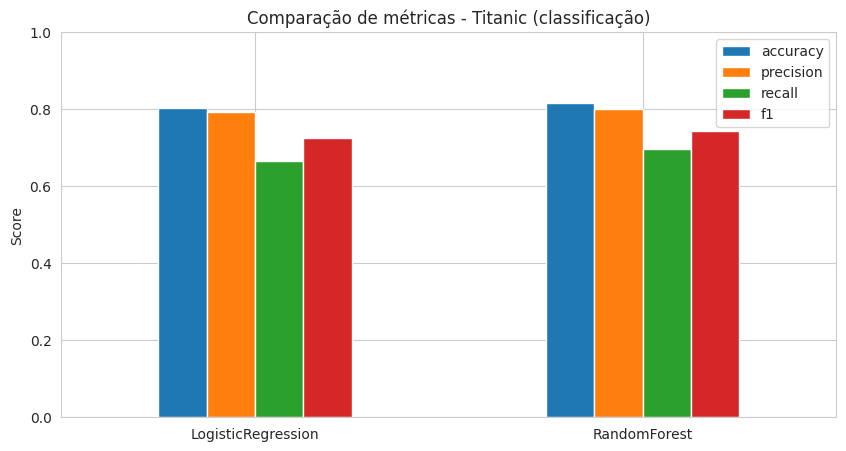

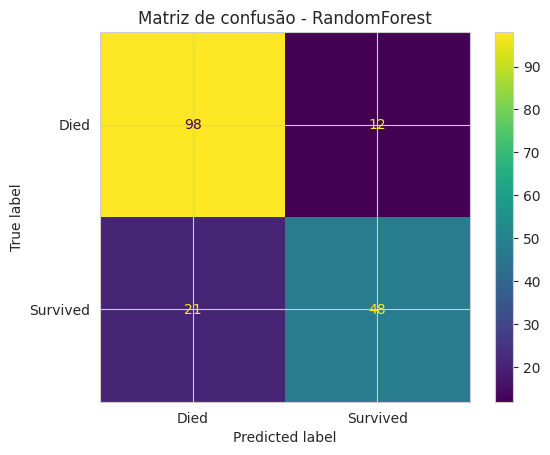

In [5]:
ax = res_clf.plot.bar(rot=0, figsize=(10,5))
ax.set_title('Comparação de métricas - Titanic (classificação)')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

# Matriz de confusão para o melhor modelo (exemplo RandomForest)
best_name = res_clf['f1'].idxmax()
best_model = models_clf[best_name]

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_t_test_prep, y_t_test, display_labels=['Died','Survived'])
plt.title(f'Matriz de confusão - {best_name}')
plt.show()


## 7) Exploração e pré-processamento — House Prices

**Descrição rápida de tratamento:** esse dataset tem muitas colunas (numéricas e categóricas). Estratégia simples aqui:

* Separar `SalePrice` como target.
* Tratar valores ausentes: para numéricos usar median, para categóricos usar `missing` ou moda.
* Reduzir cardinalidade de categorias muito grandes (opcional) ou usar `OneHotEncoder(handle_unknown='ignore')`.
* Aplicar `StandardScaler` nos numéricos.

In [6]:
hs = houses.copy()

# Target
y_h = hs['SalePrice']
X_h = hs.drop('SalePrice', axis=1)

# Selecionar colunas numéricas e categóricas
num_cols_h = X_h.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols_h = X_h.select_dtypes(include=['object']).columns.tolist()

len(num_cols_h), len(cat_cols_h)

# Para performance, reduzir o número de features utilizando as mais correlacionadas com o target
numeric_cols = hs.select_dtypes(include=['number'])
corrs = numeric_cols.corr()['SalePrice'].abs().sort_values(ascending=False)
# pegar top 15 numéricas correlacionadas
top_num = corrs.index[1:16].tolist()

# Manter algumas categorias chave
selected_cats = ['Neighborhood','ExterQual','KitchenQual','MSZoning']

selected_features = [c for c in top_num if c in num_cols_h] + [c for c in selected_cats if c in X_h.columns]
selected_features = list(dict.fromkeys(selected_features))  # dedupe

X_h_small = X_h[selected_features].copy()
# print(X_h_small.head())
# Atualiza col lists
num_cols_sel = X_h_small.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols_sel = X_h_small.select_dtypes(include=['object']).columns.tolist()

num_pipeline_h = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline_h = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc_houses = ColumnTransformer([
    ('num', num_pipeline_h, num_cols_sel),
    ('cat', cat_pipeline_h, cat_cols_sel)
])

X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_h_small, y_h, test_size=0.2, random_state=42)

X_h_train_prep = preproc_houses.fit_transform(X_h_train)
X_h_test_prep = preproc_houses.transform(X_h_test)

print('After preprocess shapes:', X_h_train_prep.shape, X_h_test_prep.shape)


After preprocess shapes: (1168, 53) (292, 53)


## 8) Treinando modelos de regressão
**Modelos escolhidos:**

* Linear Regression (baseline).
* Random Forest Regressor (modelo não-linear, robusto).

Usaremos métricas: RMSE, MAE, R² e compararemos.



In [7]:
reg1 = LinearRegression()
reg2 = RandomForestRegressor(n_estimators=200, random_state=42)

models_reg = {'LinearRegression': reg1, 'RandomForestRegressor': reg2}

def eval_regressors(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return pd.DataFrame(results).T

res_reg = eval_regressors(models_reg, X_h_train_prep, X_h_test_prep, y_h_train, y_h_test)
res_reg


,RMSE,MAE,R2
LinearRegression,32775.172788,19661.736097,0.859952
RandomForestRegressor,29771.573321,18062.161393,0.884445



## 9) Plots comparativos — Regressão


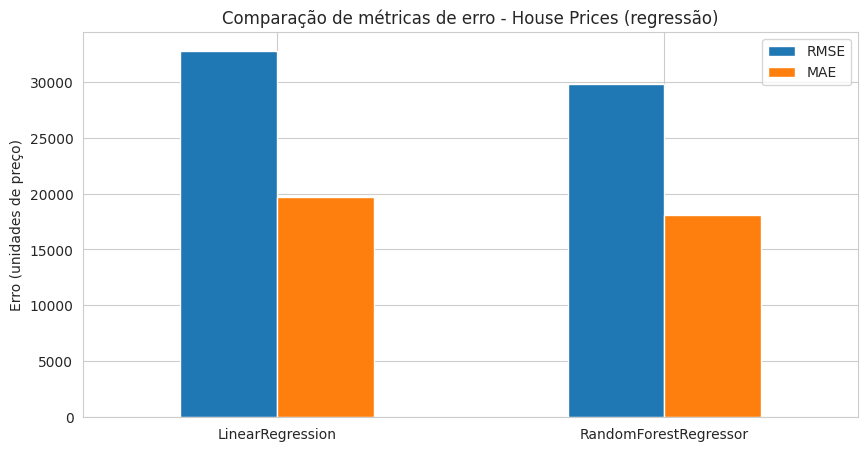

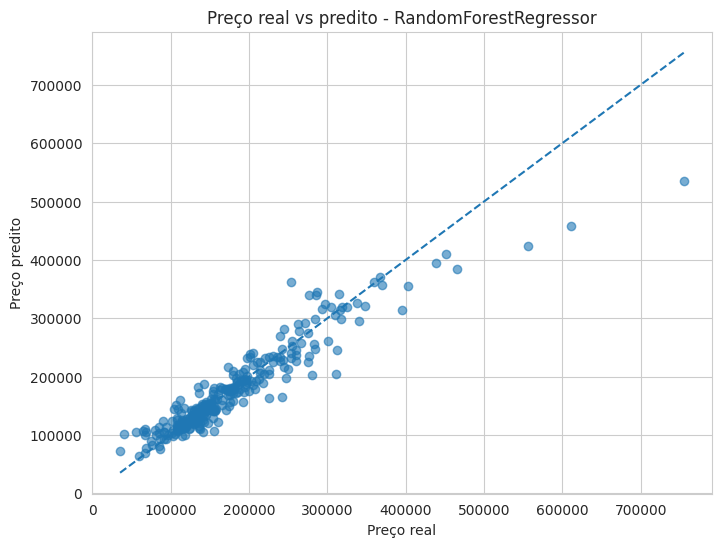

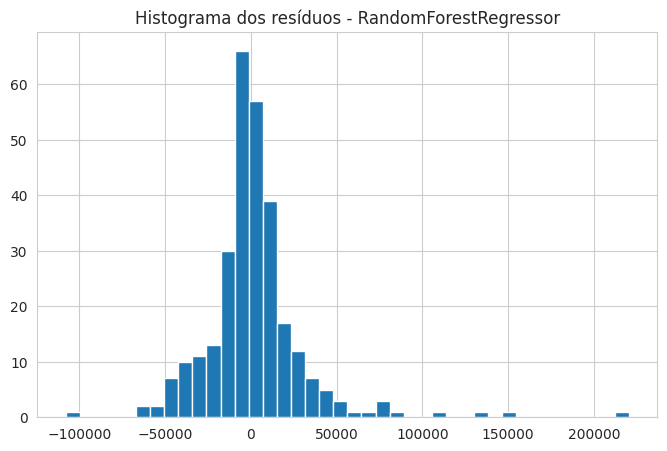

In [8]:
ax = res_reg[['RMSE','MAE']].plot.bar(rot=0, figsize=(10,5))
ax.set_title('Comparação de métricas de erro - House Prices (regressão)')
plt.ylabel('Erro (unidades de preço)')
plt.show()

# Plot de verdade vs predito para o melhor modelo (menor RMSE)
best_name_r = res_reg['RMSE'].idxmin()
best_reg = models_reg[best_name_r]

y_pred_best = best_reg.predict(X_h_test_prep)
plt.figure(figsize=(8,6))
plt.scatter(y_h_test, y_pred_best, alpha=0.6)
plt.plot([y_h_test.min(), y_h_test.max()], [y_h_test.min(), y_h_test.max()], '--')
plt.xlabel('Preço real')
plt.ylabel('Preço predito')
plt.title(f'Preço real vs predito - {best_name_r}')
plt.show()

# Residuals
residuals = y_h_test - y_pred_best
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40)
plt.title('Histograma dos resíduos - ' + best_name_r)
plt.show()
